# Machine Learning Pipeline for Queen Bee Acoustic Monitoring

A complete end-to-end prototype to detect **Queen Bee Presence** from **Hive audio recordings** using a Machine Learning pipeline.

---

## Live Demo
<div class="alert alert-block alert-success">
Note:
You can try the deployed model and download a sample audio file to test it.
</div>

<span style="display: inline-block;">
  <a href="http://3.109.237.216:5173/">
    <img src="https://img.shields.io/badge/Live-Demo-blue" alt="Live Demo">
  </a>
</span>

<span style="display: inline-block;" >
<a href="https://drive.google.com/drive/folders/1KFmHH304soDKXbLvlohWBJ-qVzudjTgZ?usp=sharing">
    <img src="https://img.shields.io/badge/Google%20Drive-Sample%20Data-blue?logo=google-drive&logoColor=white" alt="Google Drive">
</a>
</span>
    
<span style="display: inline-block;">
<a href="https://github.com/Harsh-1711/BuzzDetect">
  <img src="https://img.shields.io/badge/GitHub-View%20Repository-blue?logo=github" alt="GitHub Repo">
</a>
</span>
<span style="display: inline-block;">
  <a href="https://drive.google.com/file/d/1-SGfCbHHD-mDmvG1dTvz64QDQVDCIDsr/view?usp=sharing" target="_blank">
    <img src="https://img.shields.io/badge/Demo-Video-green?logo=google-drive" alt="Demo Video">
  </a>
</span>

---

This notebook demonstrates a complete pipeline for processing hive audio recordings and applying machine learning to detect the presence of the queen bee. 
It covers audio feature extraction, dataset preparation, model training, evaluation, and inference.

# Install libraries

##### Requirements.txt

    librosa==0.11.0
    scikit-learn==1.6.1
    numpy==2.2.6
    pandas==2.2.3
    joblib==1.5.0
    matplotlib==3.10.3
    jupyter==1.1.1
    seaborn==0.13.2
    tqdm==4.67.1



In [2]:
"""
Import necessary libraries for the Queen Bee Detection project.

- os: For file and directory operations.
- numpy: For numerical operations on arrays and matrices.
- pandas: For structured data handling (dataframes).
- matplotlib & seaborn: For data visualization.
- librosa: For audio processing and feature extraction.
- sklearn: For machine learning model building and evaluation.
- joblib: For saving and loading trained machine learning models.
"""
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score, auc
)
import seaborn as sns
import joblib
from tqdm import tqdm


## 1. Data Loading and Exploration
#### 📌 Objective:
    Load the state_labels.csv file from the dataset and plot a graph showing the total no. of dataset for each category.
    
<div class="alert alert-block alert-success">
    Dataset Source:
</div>
        
  - This dataset was sourced from https://zenodo.org/records/2667806.
  - It contains labeled audio recordings from beehives for Queen Bee detection.
  - Download only 2 folders and a labelled csv file:
    1. Queenbee present audio (https://zenodo.org/records/2667806/files/Hive1_12_06_2018.rar?download=1)
    2. Queenbee absent audio (https://zenodo.org/records/2667806/files/Hive1_31_05_2018.rar?download=1)
    3. State_labels.csv (https://zenodo.org/records/2667806/files/state_labels.csv?download=1)    


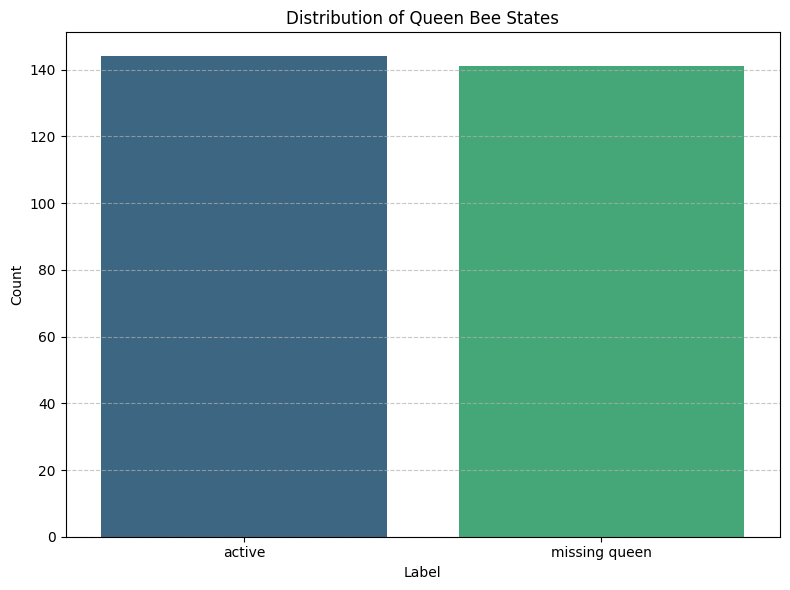

Label distribution:
label
active           144
missing queen    141
Name: count, dtype: int64


In [4]:
"""Load and Visualize Label Distribution in the Dataset"""

# Define dataset directory and label CSV file path
data_dir = "../../dataset"
labels_file = os.path.join(data_dir, 'state_labels.csv')

# Load label data into a DataFrame
labels_df = pd.read_csv(labels_file)

# Visualize class distribution using seaborn
plt.figure(figsize=(8, 6))
sns.countplot(data=labels_df, x='label', hue='label', palette='viridis')
plt.title('Distribution of Queen Bee States')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display count of each class
print("Label distribution:")
print(labels_df['label'].value_counts())


## 2. Feature Extraction Functions
#### 📌 Objective:
    Extracts a rich set of audio features with preprocessing steps to improve classification accuracy.

In [3]:

def extract_features(audio_path, include_mfcc_stats=True):
    """
    Extracts a rich set of audio features with preprocessing steps to improve classification accuracy.

    Preprocessing steps:
    - Silence trimming
    - Amplitude normalization

    Features extracted:
    - MFCCs (13)
    - Mel Spectrogram (128 bands)
    - Spectral Centroid
    - Spectral Bandwidth
    - Spectral Rolloff
    - Zero Crossing Rate

    Args:
        audio_path (str): Path to the WAV audio file.
        include_mfcc_stats (bool): Whether to include MFCC mean & std per coefficient.

    Returns:
        tuple:
            - np.ndarray: Combined feature vector.
            - np.ndarray: Raw audio time series (after preprocessing).
            - int: Sample rate.
            - np.ndarray: MFCC features.
            - np.ndarray: Mel Spectrogram (dB-scaled).
    """
    try:
        # Load audio (preserve original sample rate)
        y, sr = librosa.load(audio_path, sr=None)

        # Silence trimming
        y, _ = librosa.effects.trim(y, top_db=20)

        # Amplitude normalization
        if np.max(np.abs(y)) != 0:
            y = y / np.max(np.abs(y))

        # Feature extraction
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)

        features = []

        # Add basic feature stats (mean, std, min, max)
        for feature in [spectral_centroid, spectral_bandwidth, spectral_rolloff, zero_crossing_rate]:
            features.extend([
                np.mean(feature),
                np.std(feature),
                np.min(feature),
                np.max(feature)
            ])

        # Add mel spectrogram stats
        for i in range(mel_spec_db.shape[0]):
            features.extend([
                np.mean(mel_spec_db[i]),
                np.std(mel_spec_db[i])
            ])

        # Optionally add MFCC stats
        if include_mfcc_stats:
            for i in range(mfccs.shape[0]):
                features.extend([
                    np.mean(mfccs[i]),
                    np.std(mfccs[i])
                ])

        return np.array(features), y, sr, mfccs, mel_spec_db

    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None, None, None, None, None


## 3. Visualize Audio Features
#### 📌 Objective:
    Plots key audio features: waveform, MFCCs, and Mel spectrogram.


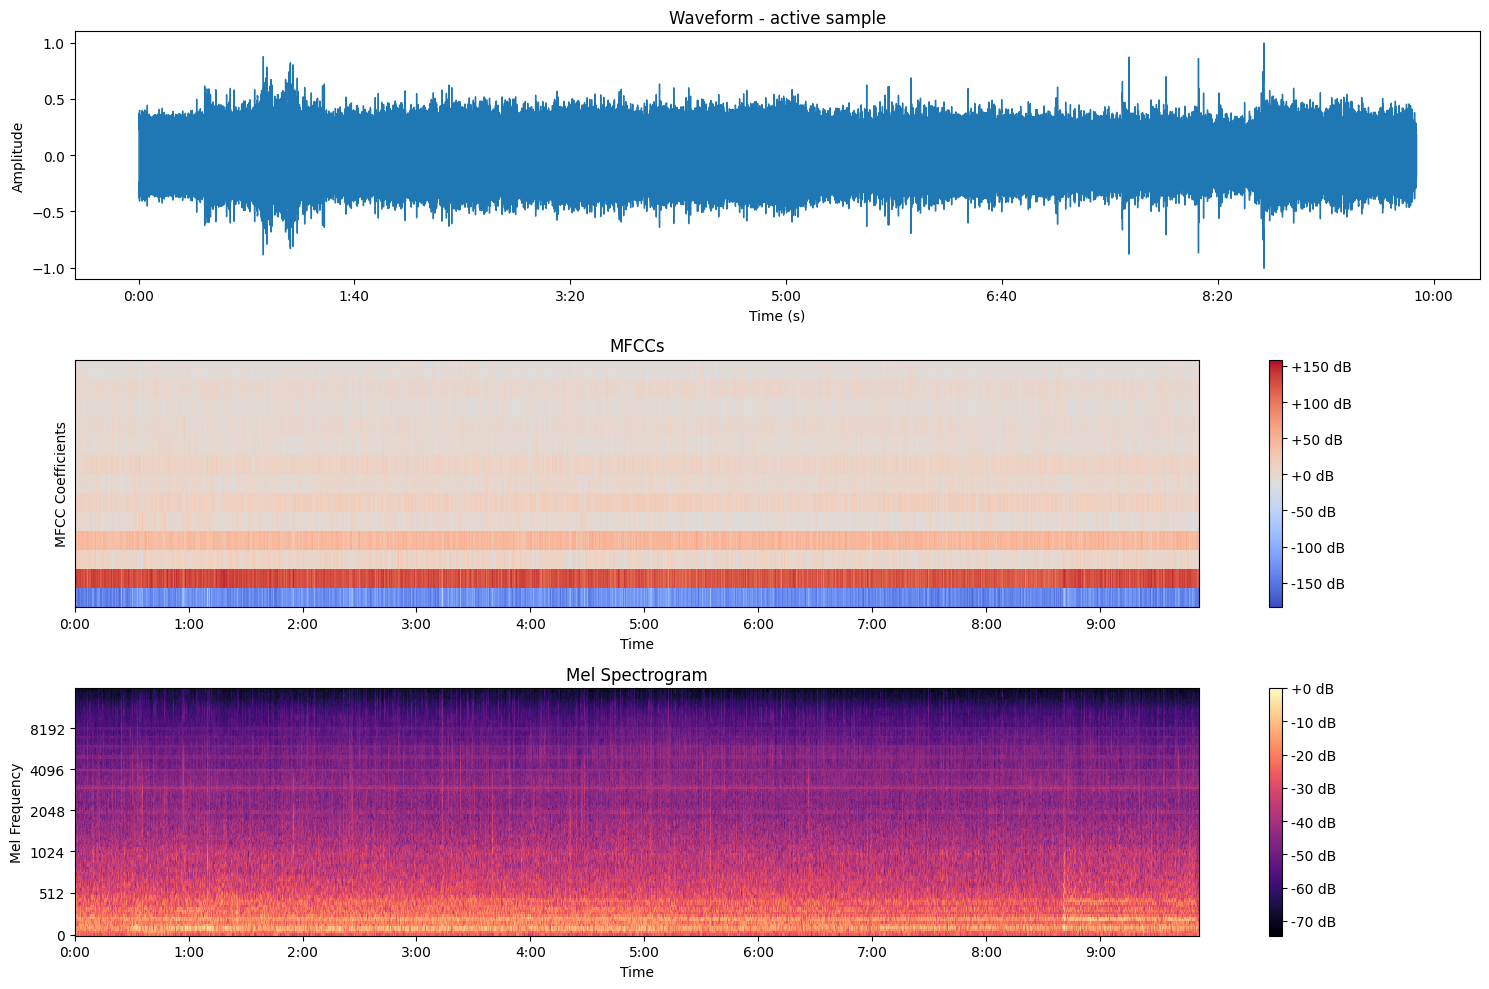

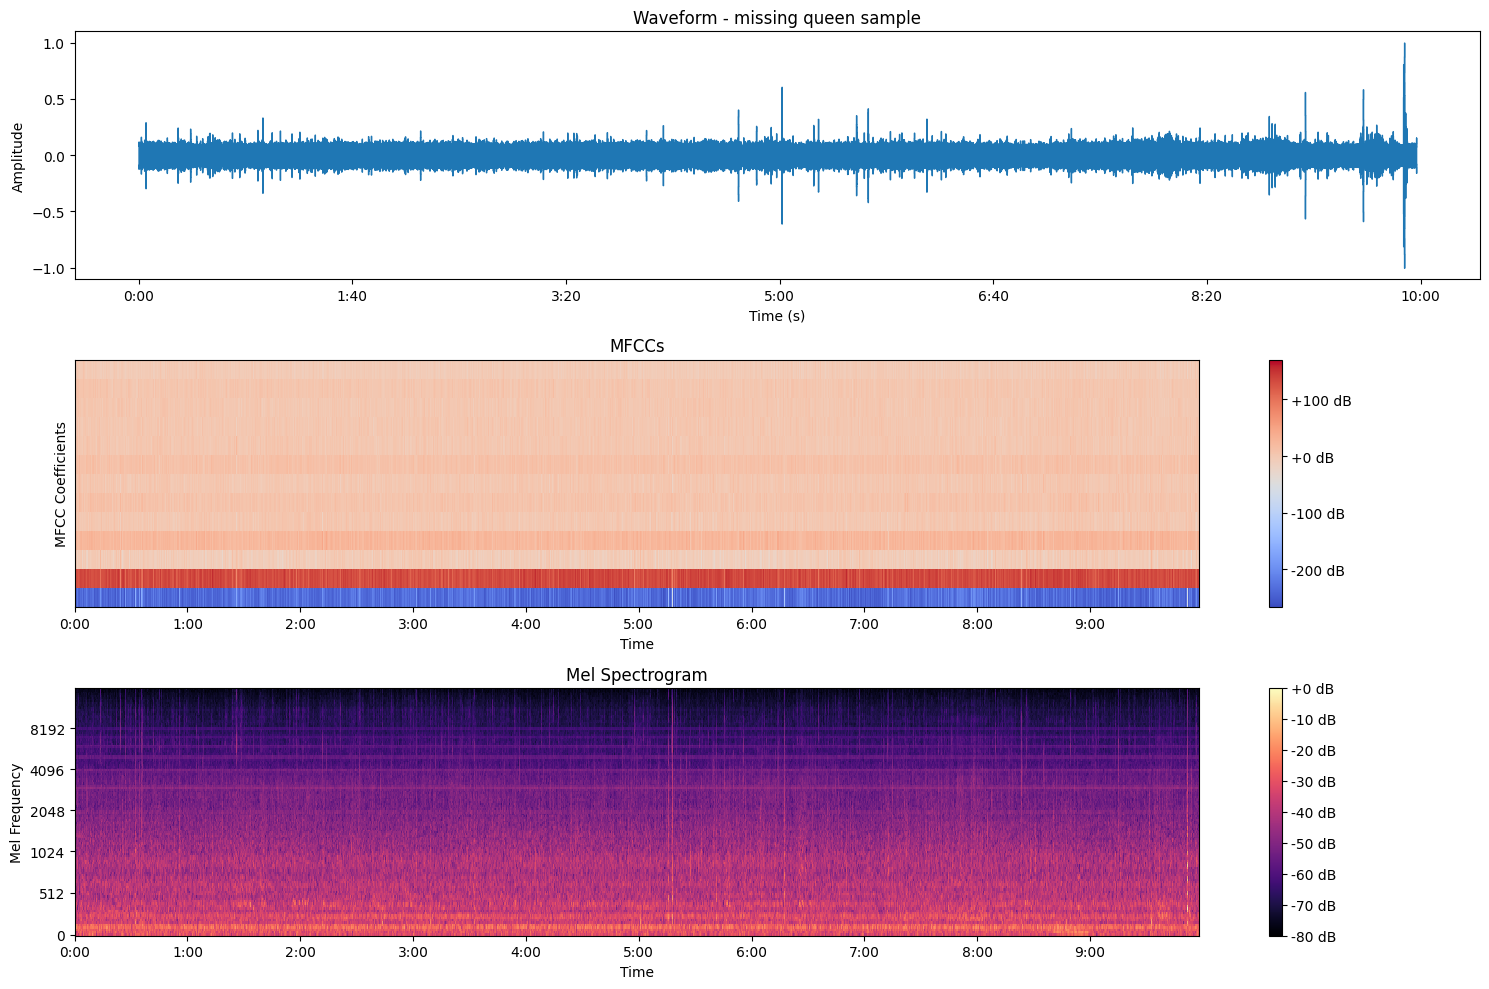

In [4]:
def plot_audio_features(y, sr, mfccs, mel_spec_db, title):
    """
    Plots key audio features: waveform, MFCCs, and Mel spectrogram.

    Args:
        y (np.ndarray): Audio time series.
        sr (int): Sampling rate of the audio.
        mfccs (np.ndarray): MFCC feature matrix.
        mel_spec_db (np.ndarray): Mel spectrogram in decibel scale.
        title (str): Title to display above the waveform.
    """
    plt.figure(figsize=(15, 10))

    # Plot waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - {title}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot MFCCs
    plt.subplot(3, 1, 2)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCCs')
    plt.ylabel('MFCC Coefficients')

    # Plot Mel Spectrogram
    plt.subplot(3, 1, 3)
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.ylabel('Mel Frequency')

    plt.tight_layout()
    plt.show()


# Plot feature visualizations for one sample per class
for label in ['active', 'missing queen']:
    # Get the first sample of the current label
    sample = labels_df[labels_df['label'] == label].iloc[0]
    sample_name = sample['sample_name']

    # Determine folder based on file name pattern
    if 'NO_QueenBee' in sample_name:
        audio_dir = os.path.join(data_dir, 'NoQueen Bee')
    else:
        audio_dir = os.path.join(data_dir, 'Queen Bee')

    # Locate the full audio file path
    audio_file = next(
        (os.path.join(audio_dir, file) for file in os.listdir(audio_dir) if sample_name in file),
        None
    )

    # Extract and plot features if file exists
    if audio_file:
        features, y, sr, mfccs, mel_spec_db = extract_features(audio_file)
        if features is not None:
            plot_audio_features(y, sr, mfccs, mel_spec_db, f"{label} sample")


## 4. Prepare Dataset
#### 📌 Objective:
    Prepares the dataset by loading labeled audio files, extracting features, and returning
    feature vectors along with binary labels.

In [29]:
def prepare_dataset(data_dir, labels_file):
    """
    Prepares the dataset by loading labeled audio files, extracting features, and returning
    feature vectors along with binary labels.

    This function processes each entry in the given CSV file, determines the correct audio
    directory ('Queen Bee' or 'NoQueen Bee') based on the sample name, extracts audio features
    using the `extract_features` function, and assigns a binary label.

    Args:
        data_dir (str): Path to the dataset directory containing subfolders:
                        - 'Queen Bee' for audio files with queen present.
                        - 'NoQueen Bee' for audio files with queen missing.
        labels_file (str): Path to the CSV file containing:
                           - 'sample_name': filename pattern to identify the audio file.
                           - 'label': either 'active' (queen present) or 'missing queen'.

    Returns:
        tuple:
            - X (np.ndarray): 2D array of shape (n_samples, n_features), each row is a feature vector.
            - y (np.ndarray): 1D array of binary labels where 1 = 'active', 0 = 'missing queen'.
    """
    labels_df = pd.read_csv(labels_file)
    features = []
    labels = []

    for _, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc="Processing audio files"):
        sample_name = row['sample_name']
        label = row['label']
        audio_dir = os.path.join(data_dir, 'NoQueen Bee') if 'NO_QueenBee' in sample_name else os.path.join(data_dir, 'Queen Bee')
        audio_file = next((os.path.join(audio_dir, file) for file in os.listdir(audio_dir) if sample_name in file), None)
        if audio_file:
            feature_vector, _, _, _, _ = extract_features(audio_file, include_mfcc_stats=True)
            if feature_vector is not None:
                features.append(feature_vector)
                labels.append(1 if label == 'active' else 0)

    return np.array(features), np.array(labels)

# Usage
X, y = prepare_dataset(data_dir, labels_file)
print(f"Feature matrix shape: {X.shape}")
print(f"Number of samples: {len(y)}")


Processing audio files: 100%|██████████| 285/285 [45:27<00:00,  9.57s/it]

Feature matrix shape: (285, 298)
Number of samples: 285


In [5]:
""" 
Save the Dataset for future use. You dont need to prepare dataset again if you save it into your local machine.
Remove comments if you are executing dataset for the first time then comment again!
"""
# df = pd.DataFrame(X)
# df['label'] = y
# df.to_csv('../../dataset/queenbee_dataset.csv', index=False)


"""
Loads preprocessed Queen Bee dataset from a CSV file.

The CSV is assumed to contain audio feature vectors (as columns) and a 'label' column,
where:
- Features: numerical values extracted from audio files.
- Label: binary classification target (1 for 'active', 0 for 'missing queen').

This is useful when the feature extraction is done once and reused across experiments.

Returns:
    X_loaded (np.ndarray): Feature matrix from CSV (excluding label column).
    y_loaded (np.ndarray): Label vector from the 'label' column.
"""

df_loaded = pd.read_csv('../../dataset/queenbee_dataset.csv')
X_loaded = df_loaded.iloc[:, :-1].values
y_loaded = df_loaded['label'].values

## 5. Model Training & Hyperparameter Tuning
#### 📌 Objective:
    Train a RandomForestClassifier using different values for n_estimators and evaluate the best one using a validation set.
        Steps Covered:
        1.Data Splitting
            70% → Training
            15% → Validation
            15% → Testing
        2.Feature Scaling
            Fit scaler only on the training data.
            Transform validation and test using the same scaler.
        3.Hyperparameter Tuning
            Try n_estimators = [50, 100, 150, 200, 250].
            Evaluate using validation accuracy.
            Track the best model.
        4.Final Training
            Combine training and validation sets.
            Retrain using the best n_estimators.
        5.Model Evaluation
            Evaluate on the test set.
            Compute Accuracy and F1 Score

In [6]:
"""
Trains a Random Forest with hyperparameter tuning using a validation set.
Evaluates final model on test set.

Args:
    X (np.ndarray): Feature matrix.
    y (np.ndarray): Label vector.
    random_state (int): Random seed for reproducibility.

Returns:
    best_model (RandomForestClassifier): Best trained Random Forest model.
    best_n_estimators (int): Best number of trees chosen from validation.
    test_accuracy (float): Accuracy on the test set.
    f1 (float): F1 score on the test set.
"""
# Step 1: Split data (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_loaded, y_loaded, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Step 2: Scale features (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 3: Hyperparameter tuning (trying multiple values of n_estimators)
best_val_accuracy = 0
best_model = None
best_n_estimators = 0

for n in [50, 100, 150, 200, 250]:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train_scaled, y_train)
    val_accuracy = model.score(X_val_scaled, y_val)
    print(f"n_estimators = {n}, Validation Accuracy = {val_accuracy:.4f}")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model
        best_n_estimators = n

# Step 4: Retrain final model on combined training + validation data
X_final_train = np.concatenate((X_train_scaled, X_val_scaled))
y_final_train = np.concatenate((y_train, y_val))

final_model = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
final_model.fit(X_final_train, y_final_train)

# Step 5: Evaluate on the test set
X_test_scaled = scaler.transform(X_test)
test_accuracy = final_model.score(X_test_scaled, y_test)
y_pred = final_model.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred)

print("\n🔍 Final Evaluation")
print(f"Best n_estimators: {best_n_estimators}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

n_estimators = 50, Validation Accuracy = 0.9302
n_estimators = 100, Validation Accuracy = 0.9535
n_estimators = 150, Validation Accuracy = 0.9535
n_estimators = 200, Validation Accuracy = 0.9535
n_estimators = 250, Validation Accuracy = 0.9535

🔍 Final Evaluation
Best n_estimators: 100
Test Accuracy: 0.9070
F1 Score: 0.9000


In [19]:
"""
Saves the trained model and scaler objects to disk using joblib.

Args:
model: Trained machine learning model (e.g., RandomForestClassifier).
Scaler: Scaler object used for feature scaling (e.g., StandardScaler).
"""

joblib.dump(model, '../model/queenbee_rf_model.pkl')
joblib.dump(scaler, '../model/scaler.pkl')

['../model/scaler.pkl']

In [7]:

# Evaluation Metrics and Visualizations

# Generate predicted probabilities
y_prob = model.predict_proba(X_test_scaled)[:, 1]
y_pred = model.predict(X_test_scaled)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Accuracy: 0.9070
Precision: 0.9474
Recall: 0.8571
F1 Score: 0.9000
ROC AUC: 0.9762


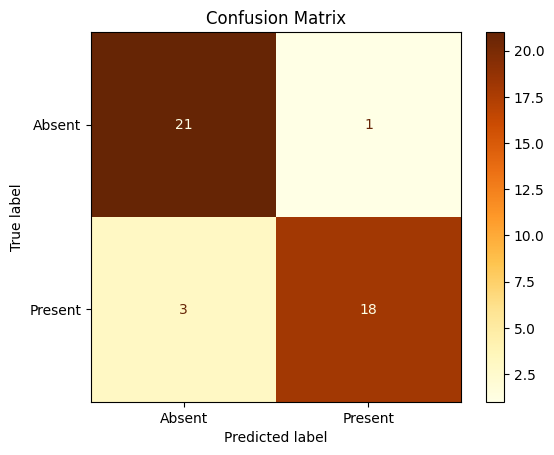

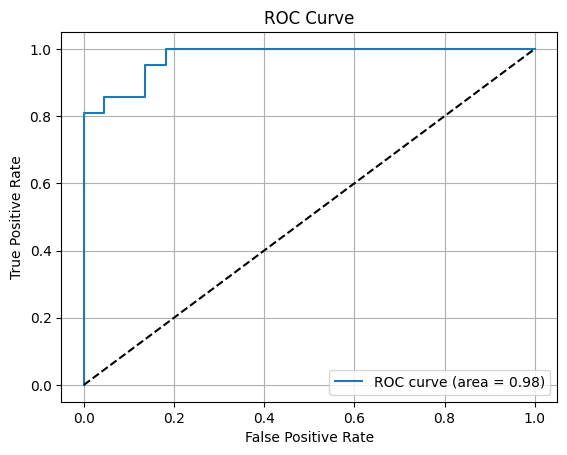

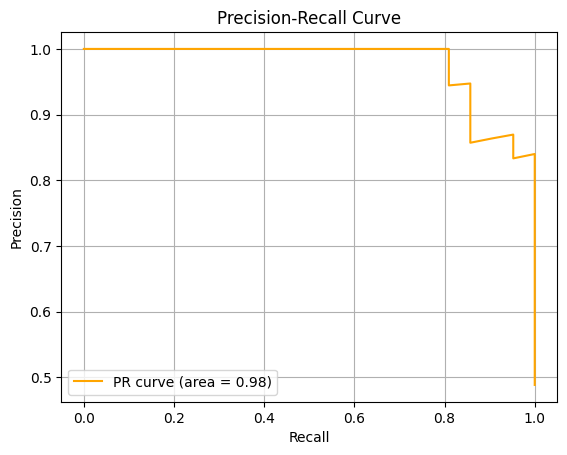

In [17]:

# 📈 Confusion Matrix and Curves

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Absent", "Present"])
disp.plot(cmap=plt.cm.YlOrBr)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_val:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
pr_auc_val = auc(recall_vals, precision_vals)
plt.plot(recall_vals, precision_vals, label=f"PR curve (area = {pr_auc_val:.2f})", color="orange")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


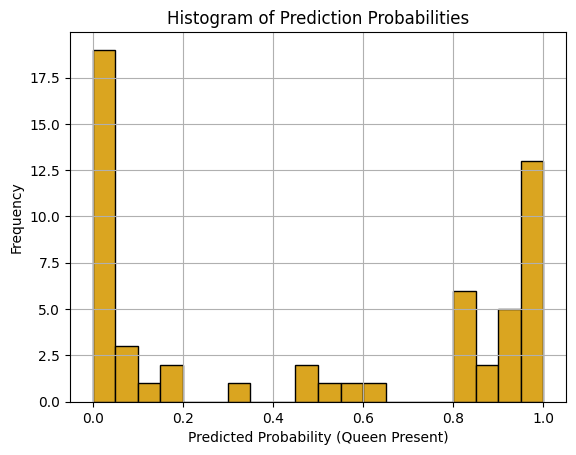

In [49]:

# 📊 Histogram of Prediction Probabilities

plt.hist(y_prob, bins=20, color='goldenrod', edgecolor='black')
plt.title("Histogram of Prediction Probabilities")
plt.xlabel("Predicted Probability (Queen Present)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



### 🔍 Evaluation Commentary

The model performs classification on queen bee presence with key metrics like accuracy, precision, recall, F1-score, and ROC-AUC. The ROC and PR curves help visualize the trade-offs and classification confidence.

- A well-separated ROC curve suggests the model is distinguishing well between classes.
- The confusion matrix provides insight into false positives/negatives.
- The histogram shows the model’s confidence across test predictions.

This supports decision-making when analyzing new hive audio files.



## 6. Prediction and Audio Feature Visualization
### 📌 Objective:
Visualize key audio features from a sound signal to better understand the characteristics of the data.

#### Features Plotted:
    1. Waveform
        Time domain representation of the audio signal (amplitude over time).

    2. Mel Spectrogram (dB)
        Frequency content over time represented using the mel scale in decibels.

    3. MFCC (Mel-Frequency Cepstral Coefficients)
        Represents the short-term power spectrum of the sound, commonly used in audio classification.

    4. Zero Crossing Rate
        Measures how frequently the signal changes sign (from positive to negative or vice versa), useful for analyzing noisiness or percussive qualities.

In [ ]:
def create_feature_plots(y, sr, mfccs, mel_spec_db):
    """
    Visualizes key audio features extracted from a sound signal.

    This function plots the waveform, mel spectrogram (in decibels), MFCCs (Mel-Frequency Cepstral Coefficients),
    and the zero crossing rate of the given audio signal in a 2x2 subplot layout.

    Parameters
    ----------
    y : np.ndarray
        The audio time series.
    
    sr : int
        Sampling rate of the audio signal.
    
    mfccs : np.ndarray
        Mel-frequency cepstral coefficients of the audio signal.
    
    mel_spec_db : np.ndarray
        Mel-scaled spectrogram in decibel units.

    Returns
    -------
    None
        Displays the plots using matplotlib.
    """
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    
    # Waveform
    librosa.display.waveshow(y, sr=sr, ax=axs[0, 0])
    axs[0, 0].set_title("Waveform\n(Time domain representation of the audio signal)", fontsize=14)
    axs[0, 0].set_xlabel("Time (seconds)", fontsize=12)
    axs[0, 0].set_ylabel("Amplitude", fontsize=12)
    
    # Mel Spectrogram (dB)
    img1 = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axs[0, 1])
    axs[0, 1].set_title("Mel Spectrogram (dB)\n(Frequency content over time using Mel scale)", fontsize=14)
    axs[0, 1].set_xlabel("Time (seconds)", fontsize=12)
    axs[0, 1].set_ylabel("Mel Frequency (Hz)", fontsize=12)
    fig.colorbar(img1, ax=axs[0, 1], format="%+2.0f dB", label="Decibels (dB)")
    
    # MFCC
    img2 = librosa.display.specshow(mfccs, x_axis='time', sr=sr, ax=axs[1, 0])
    axs[1, 0].set_title("MFCC (Mel-Frequency Cepstral Coefficients)\n(Representation of the short-term power spectrum of sound)", fontsize=14)
    axs[1, 0].set_xlabel("Time (seconds)", fontsize=12)
    axs[1, 0].set_ylabel("MFCC Coefficient Index", fontsize=12)
    fig.colorbar(img2, ax=axs[1, 0], label="Coefficient Amplitude")
    
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    time = np.linspace(0, len(y) / sr, num=len(zcr[0]))
    axs[1, 1].plot(time, zcr[0], color='orange')
    axs[1, 1].set_title("Zero Crossing Rate\n(Rate at which the audio signal changes sign)", fontsize=14)
    axs[1, 1].set_xlabel("Time (seconds)", fontsize=12)
    axs[1, 1].set_ylabel("Zero Crossing Rate", fontsize=12)
    axs[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()


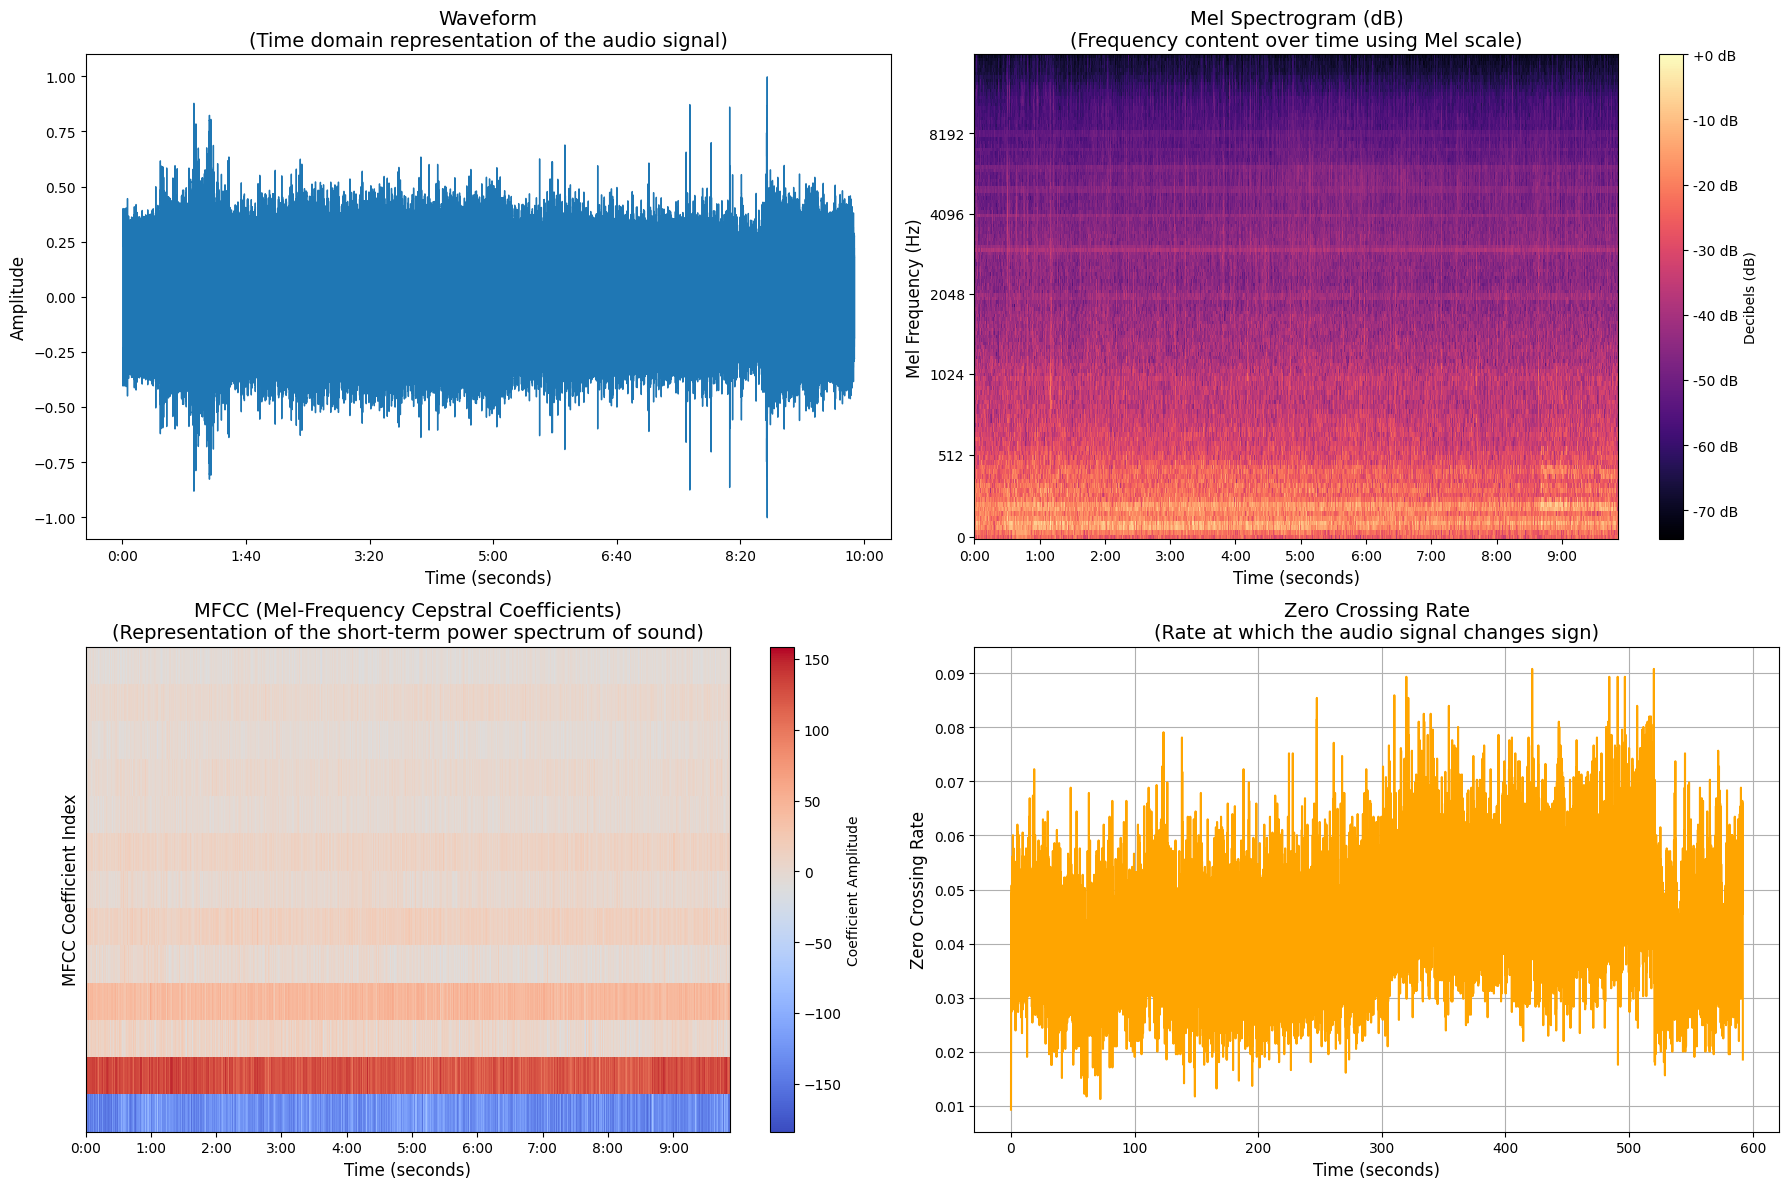

Prediction: Queen Bee is Present (Confidence: 0.98)


In [21]:
model = joblib.load('../model/queenbee_rf_model.pkl')
scaler = joblib.load('../model/scaler.pkl')

def predict_audio(file_path):
    """
    Predicts the presence of a queen bee from an audio file using the trained model.

    Args:
        file_path (str): Path to the audio file for prediction.

    Returns:
        dict: {
            'label': str,          # "Queen Bee is Present" or "Queen Bee is Absent"
            'confidence': float    # Probability/confidence of the prediction (0 to 1)
        } or None if feature extraction fails.
    """
    feature_vector, y, sr, mfccs, mel_spec_db = extract_features(file_path, include_mfcc_stats=True)
    if feature_vector is not None:
        feature_vector_scaled = scaler.transform([feature_vector])
        prediction = model.predict(feature_vector_scaled)[0]
        prob = model.predict_proba(feature_vector_scaled)[0].max()
        label = "Queen Bee is Present" if prediction == 1 else "Queen Bee is Absent"
        create_feature_plots(y, sr, mfccs, mel_spec_db)
        print(f"Prediction: {label} (Confidence: {prob:.2f})")
    else:
        print("Could not extract features from audio.")

# 🔍 Replace this with your test file path
predict_audio("../../dataset/Queen Bee/Hive1 12_06_2018_QueenBee____00_00_00.wav")